In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk import word_tokenize
from nltk.corpus import stopwords
from string import punctuation
from yellowbrick.text import FreqDistVisualizer
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

In [6]:
import sys
sys.path.insert(0, './modules')
from helpers import preproc_text1, preproc_text2

In [12]:
kiva = pd.read_csv('derived_data/kiva_01.csv')
kiva.shape

(6818, 7)

## Preprocessing & Text Feature Engineering

In [13]:
# Map target to numerical values
kiva['status'] = kiva.status.map({'defaulted': 1, 'paid': 0})

# Create dummy variables for categorical features
cat_cols = ['sector', 'country', 'gender', 'nonpayment']
dummy_cols = pd.get_dummies(kiva[cat_cols], drop_first=True);
kiva = kiva.drop(columns=cat_cols).join(dummy_cols);

# Create word flags
kiva['married'] = kiva['en'].str.contains('married', case=False)
kiva['group_lending'] = kiva['en'].str.contains('solidarity', case=False)
kiva['risk'] = kiva['en'].str.contains('higher default risk', case=False)

# Create text feature - number of upper-case letters - before case normalization
kiva['n_upper'] = kiva['en'].apply(lambda x: len([x for x in word_tokenize(x) if x.isupper()]))

Perform initial text preprocessing to remove unwanted content, HTML tags, line breaks and non-unicode characters.

In [14]:
kiva['en'] = kiva['en'].apply(preproc_text1)

Create more text features before the final cleaning.

In [15]:
# Number of words: indicate the length of the description (reflect how much time the writer spent
# on writing the application and how serious he/she was about the application)
kiva['n_words'] = kiva['en'].apply(lambda x: len(word_tokenize(x)))

# Number of characters: same as above
kiva['n_char'] = kiva['en'].apply(len)

# Average word length: indicate overall word complexity (could reflect writer's education level)
kiva['avg_word_len'] = kiva['n_char'] / kiva['n_words']

# Number of stopwords: indicate writer's writing habits
kiva['n_stopwords'] = kiva['en'].apply(lambda x: len([x for x in word_tokenize(x)
                                                      if x in stopwords.words('english')]))

# Number of numbers: indicate writer's writing habits
kiva['n_numbers'] = kiva['en'].apply(lambda x: len([x for x in word_tokenize(x)
                                                    if x.isdigit()]))

# Number of punctuations: indicate writer's writing habits
kiva['n_punc'] = kiva['en'].apply(lambda x: len([x for x in word_tokenize(x)
                                                 if x in punctuation]))

# Drop missing values created by the preprocessing
kiva.dropna(inplace=True)

Perform final cleaning.

In [19]:
kiva['en'] = kiva['en'].apply(preproc_text2)

## Visualize Cleaned Text

#### Plot top 50 most frequent words for 'paid' category

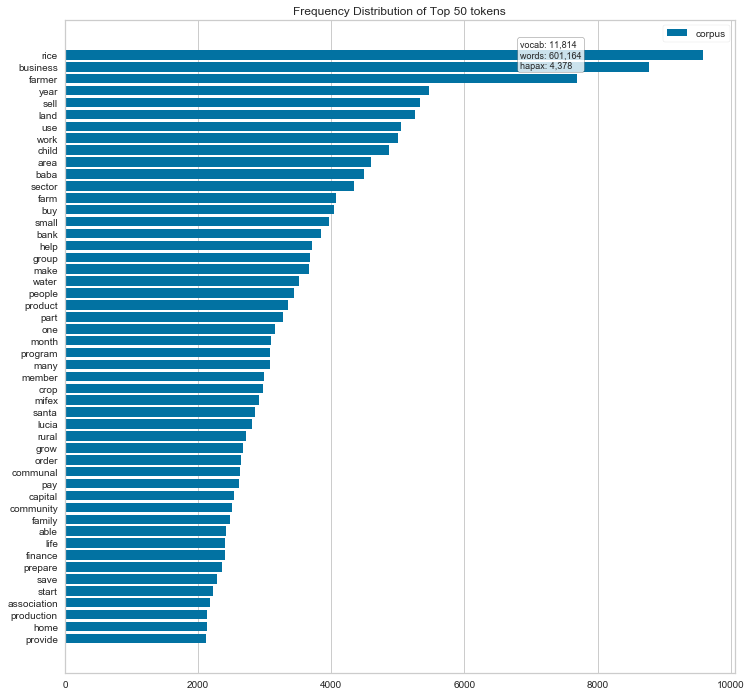

In [31]:
vec = CountVectorizer()
paid = kiva[kiva['status'] == 0]['en']
docs = vec.fit_transform(words for words in paid)
plt.figure(figsize=(12, 12))
features = vec.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n=50)
visualizer.fit(docs)
visualizer.poof()

#### Plot top 50 most frequent words for 'defaulted' category

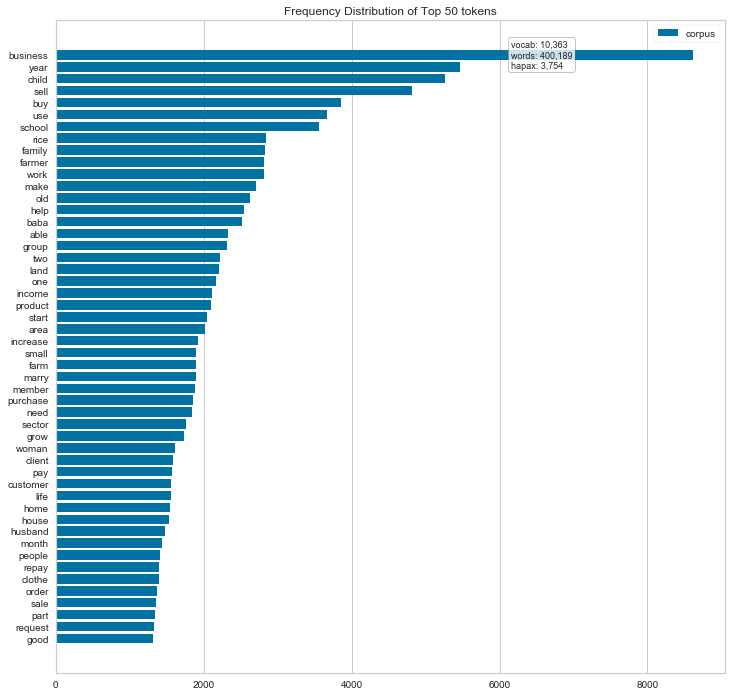

In [34]:
defaulted = kiva[kiva['status'] == 1]['en']
docs = vec.fit_transform(words for words in defaulted)
plt.figure(figsize=(12, 12))
features = vec.get_feature_names()
visualizer = FreqDistVisualizer(features=features, n=50)
visualizer.fit(docs)
visualizer.poof()

## Export Cleaned Dataset

In [20]:
kiva.to_csv('derived_data/kiva_02.csv', index=False)